In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Hyperparameters
INPUT_DIM = 2
COUPLING_DIM = 256
COUPLING_LAYERS = 4
BATCH_SIZE = 256
LR = 1e-4
EPOCHS = 300
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
# Dataset
class MoonsDataset(Dataset):
    def __init__(self, n_samples=30000, noise=0.05):
        data, _ = make_moons(n_samples=n_samples, noise=noise)
        self.data = ((data - data.mean(0)) / data.std(0)).astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [3]:
# Corrected Coupling Layer
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2), nn.Tanh())

        self.translate_net = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2))

    def forward(self, x, mask, reverse=False):
        x_a = x * mask
        x_b = x * (1 - mask)

        # Pass only x_a's non-zero dimensions to the networks
        x_a_cond = x_a[:, mask.bool()]

        s = self.scale_net(x_a_cond)
        t = self.translate_net(x_a_cond)

        if not reverse:
            y_b = (x_b[:, (1 - mask).bool()] * torch.exp(s)) + t
            log_det_jac = s.sum(dim=1)
        else:
            y_b = (x_b[:, (1 - mask).bool()] - t) * torch.exp(-s)
            log_det_jac = -s.sum(dim=1)

        # Reconstruct the output
        y = torch.zeros_like(x)
        y[:, mask.bool()] = x_a_cond
        y[:, (1 - mask).bool()] = y_b

        return y, log_det_jac


# RealNVP Model
class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_flows):
        super().__init__()
        self.prior = torch.distributions.MultivariateNormal(torch.zeros(input_dim).to(DEVICE), torch.eye(input_dim).to(DEVICE))
        self.layers = nn.ModuleList([CouplingLayer(input_dim, hidden_dim) for _ in range(num_flows)])
        self.masks = [torch.tensor([i % 2, (i+1) % 2]).float().to(DEVICE) for i in range(num_flows)]

    def forward(self, x):
        log_det_J = 0
        for layer, mask in zip(self.layers, self.masks):
            x, log_det = layer(x, mask)
            log_det_J += log_det
        return x, log_det_J

    def loss(self, x):
        z, log_det_J = self(x)
        log_prob = self.prior.log_prob(z)
        return -(log_det_J + log_prob).mean()

    def sample(self, num_samples):
        z = self.prior.sample((num_samples,))
        for layer, mask in reversed(list(zip(self.layers, self.masks))):
            z, _ = layer(z, mask, reverse=True)
        return z


In [4]:
def train(model, loader, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        tqdm_loader = tqdm(loader, desc=f"Training RealNVP - Epoch {epoch+1}/{epochs}")

        for batch in tqdm_loader:
            batch = batch.to(DEVICE)
            optimizer.zero_grad()
            loss = model.loss(batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            tqdm_loader.set_postfix(loss=loss.item())

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {total_loss:.6f} ")

Training RealNVP - Epoch 1/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [1/300], Train Loss: 281.982562 


Training RealNVP - Epoch 2/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [2/300], Train Loss: 247.400358 


Training RealNVP - Epoch 3/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [3/300], Train Loss: 223.739549 


Training RealNVP - Epoch 4/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [4/300], Train Loss: 209.519954 


Training RealNVP - Epoch 5/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [5/300], Train Loss: 198.416801 


Training RealNVP - Epoch 6/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [6/300], Train Loss: 194.660297 


Training RealNVP - Epoch 7/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [7/300], Train Loss: 188.446793 


Training RealNVP - Epoch 8/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [8/300], Train Loss: 188.059615 


Training RealNVP - Epoch 9/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [9/300], Train Loss: 184.760141 


Training RealNVP - Epoch 10/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [10/300], Train Loss: 180.697759 


Training RealNVP - Epoch 11/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [11/300], Train Loss: 178.524540 


Training RealNVP - Epoch 12/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [12/300], Train Loss: 177.946086 


Training RealNVP - Epoch 13/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [13/300], Train Loss: 176.972209 


Training RealNVP - Epoch 14/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [14/300], Train Loss: 177.137933 


Training RealNVP - Epoch 15/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [15/300], Train Loss: 175.977136 


Training RealNVP - Epoch 16/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [16/300], Train Loss: 172.791817 


Training RealNVP - Epoch 17/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [17/300], Train Loss: 173.503859 


Training RealNVP - Epoch 18/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [18/300], Train Loss: 172.734158 


Training RealNVP - Epoch 19/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [19/300], Train Loss: 172.068447 


Training RealNVP - Epoch 20/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [20/300], Train Loss: 174.671998 


Training RealNVP - Epoch 21/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [21/300], Train Loss: 173.108524 


Training RealNVP - Epoch 22/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [22/300], Train Loss: 172.234562 


Training RealNVP - Epoch 23/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [23/300], Train Loss: 172.624964 


Training RealNVP - Epoch 24/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [24/300], Train Loss: 172.673279 


Training RealNVP - Epoch 25/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [25/300], Train Loss: 170.267161 


Training RealNVP - Epoch 26/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [26/300], Train Loss: 173.199823 


Training RealNVP - Epoch 27/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [27/300], Train Loss: 170.816580 


Training RealNVP - Epoch 28/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [28/300], Train Loss: 170.797864 


Training RealNVP - Epoch 29/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [29/300], Train Loss: 169.081953 


Training RealNVP - Epoch 30/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [30/300], Train Loss: 168.493178 


Training RealNVP - Epoch 31/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [31/300], Train Loss: 169.786008 


Training RealNVP - Epoch 32/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [32/300], Train Loss: 177.169076 


Training RealNVP - Epoch 33/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [33/300], Train Loss: 168.985215 


Training RealNVP - Epoch 34/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [34/300], Train Loss: 170.722826 


Training RealNVP - Epoch 35/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [35/300], Train Loss: 173.577870 


Training RealNVP - Epoch 36/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [36/300], Train Loss: 175.768795 


Training RealNVP - Epoch 37/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [37/300], Train Loss: 187.450779 


Training RealNVP - Epoch 38/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [38/300], Train Loss: 179.362071 


Training RealNVP - Epoch 39/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [39/300], Train Loss: 178.979760 


Training RealNVP - Epoch 40/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [40/300], Train Loss: 170.869645 


Training RealNVP - Epoch 41/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [41/300], Train Loss: 172.720238 


Training RealNVP - Epoch 42/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [42/300], Train Loss: 169.020476 


Training RealNVP - Epoch 43/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [43/300], Train Loss: 173.240446 


Training RealNVP - Epoch 44/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [44/300], Train Loss: 167.356707 


Training RealNVP - Epoch 45/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [45/300], Train Loss: 179.287646 


Training RealNVP - Epoch 46/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [46/300], Train Loss: 175.970616 


Training RealNVP - Epoch 47/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [47/300], Train Loss: 174.979868 


Training RealNVP - Epoch 48/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [48/300], Train Loss: 174.382125 


Training RealNVP - Epoch 49/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [49/300], Train Loss: 171.849896 


Training RealNVP - Epoch 50/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [50/300], Train Loss: 171.596218 


Training RealNVP - Epoch 51/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [51/300], Train Loss: 170.418747 


Training RealNVP - Epoch 52/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [52/300], Train Loss: 177.719795 


Training RealNVP - Epoch 53/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [53/300], Train Loss: 174.295380 


Training RealNVP - Epoch 54/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [54/300], Train Loss: 174.438302 


Training RealNVP - Epoch 55/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [55/300], Train Loss: 166.364814 


Training RealNVP - Epoch 56/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [56/300], Train Loss: 168.463408 


Training RealNVP - Epoch 57/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [57/300], Train Loss: 167.699447 


Training RealNVP - Epoch 58/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [58/300], Train Loss: 164.252198 


Training RealNVP - Epoch 59/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [59/300], Train Loss: 164.363644 


Training RealNVP - Epoch 60/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [60/300], Train Loss: 168.183901 


Training RealNVP - Epoch 61/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [61/300], Train Loss: 164.769380 


Training RealNVP - Epoch 62/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [62/300], Train Loss: 176.025104 


Training RealNVP - Epoch 63/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [63/300], Train Loss: 164.685147 


Training RealNVP - Epoch 64/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [64/300], Train Loss: 163.675087 


Training RealNVP - Epoch 65/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [65/300], Train Loss: 162.756131 


Training RealNVP - Epoch 66/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [66/300], Train Loss: 164.426366 


Training RealNVP - Epoch 67/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [67/300], Train Loss: 172.817854 


Training RealNVP - Epoch 68/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [68/300], Train Loss: 163.011055 


Training RealNVP - Epoch 69/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [69/300], Train Loss: 169.830570 


Training RealNVP - Epoch 70/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [70/300], Train Loss: 166.130650 


Training RealNVP - Epoch 71/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [71/300], Train Loss: 161.220316 


Training RealNVP - Epoch 72/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [72/300], Train Loss: 163.764866 


Training RealNVP - Epoch 73/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [73/300], Train Loss: 165.325275 


Training RealNVP - Epoch 74/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [74/300], Train Loss: 160.707006 


Training RealNVP - Epoch 75/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [75/300], Train Loss: 163.932344 


Training RealNVP - Epoch 76/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [76/300], Train Loss: 161.627200 


Training RealNVP - Epoch 77/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [77/300], Train Loss: 161.458862 


Training RealNVP - Epoch 78/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [78/300], Train Loss: 159.970518 


Training RealNVP - Epoch 79/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [79/300], Train Loss: 163.683040 


Training RealNVP - Epoch 80/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [80/300], Train Loss: 163.281034 


Training RealNVP - Epoch 81/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [81/300], Train Loss: 171.866840 


Training RealNVP - Epoch 82/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [82/300], Train Loss: 178.679123 


Training RealNVP - Epoch 83/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [83/300], Train Loss: 163.581774 


Training RealNVP - Epoch 84/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [84/300], Train Loss: 170.272913 


Training RealNVP - Epoch 85/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [85/300], Train Loss: 162.753711 


Training RealNVP - Epoch 86/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [86/300], Train Loss: 161.476273 


Training RealNVP - Epoch 87/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [87/300], Train Loss: 163.678079 


Training RealNVP - Epoch 88/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [88/300], Train Loss: 166.385929 


Training RealNVP - Epoch 89/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [89/300], Train Loss: 171.750055 


Training RealNVP - Epoch 90/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [90/300], Train Loss: 173.883616 


Training RealNVP - Epoch 91/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [91/300], Train Loss: 175.338098 


Training RealNVP - Epoch 92/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [92/300], Train Loss: 170.983615 


Training RealNVP - Epoch 93/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [93/300], Train Loss: 166.777587 


Training RealNVP - Epoch 94/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [94/300], Train Loss: 164.975317 


Training RealNVP - Epoch 95/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [95/300], Train Loss: 162.632660 


Training RealNVP - Epoch 96/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [96/300], Train Loss: 165.568535 


Training RealNVP - Epoch 97/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [97/300], Train Loss: 171.015361 


Training RealNVP - Epoch 98/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [98/300], Train Loss: 166.403029 


Training RealNVP - Epoch 99/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [99/300], Train Loss: 167.266795 


Training RealNVP - Epoch 100/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [100/300], Train Loss: 182.948103 


Training RealNVP - Epoch 101/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [101/300], Train Loss: 164.995142 


Training RealNVP - Epoch 102/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [102/300], Train Loss: 179.375705 


Training RealNVP - Epoch 103/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [103/300], Train Loss: 177.747244 


Training RealNVP - Epoch 104/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [104/300], Train Loss: 170.480888 


Training RealNVP - Epoch 105/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [105/300], Train Loss: 167.574673 


Training RealNVP - Epoch 106/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [106/300], Train Loss: 169.621243 


Training RealNVP - Epoch 107/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [107/300], Train Loss: 173.553360 


Training RealNVP - Epoch 108/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [108/300], Train Loss: 170.902276 


Training RealNVP - Epoch 109/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [109/300], Train Loss: 178.072444 


Training RealNVP - Epoch 110/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [110/300], Train Loss: 170.758923 


Training RealNVP - Epoch 111/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [111/300], Train Loss: 164.591029 


Training RealNVP - Epoch 112/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [112/300], Train Loss: 164.446078 


Training RealNVP - Epoch 113/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [113/300], Train Loss: 170.329766 


Training RealNVP - Epoch 114/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [114/300], Train Loss: 163.095913 


Training RealNVP - Epoch 115/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [115/300], Train Loss: 163.151110 


Training RealNVP - Epoch 116/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [116/300], Train Loss: 164.465653 


Training RealNVP - Epoch 117/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [117/300], Train Loss: 160.775762 


Training RealNVP - Epoch 118/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [118/300], Train Loss: 160.554208 


Training RealNVP - Epoch 119/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [119/300], Train Loss: 159.067209 


Training RealNVP - Epoch 120/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [120/300], Train Loss: 159.858982 


Training RealNVP - Epoch 121/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [121/300], Train Loss: 163.719749 


Training RealNVP - Epoch 122/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [122/300], Train Loss: 159.385984 


Training RealNVP - Epoch 123/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [123/300], Train Loss: 160.019687 


Training RealNVP - Epoch 124/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [124/300], Train Loss: 156.953881 


Training RealNVP - Epoch 125/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [125/300], Train Loss: 154.765537 


Training RealNVP - Epoch 126/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [126/300], Train Loss: 162.644755 


Training RealNVP - Epoch 127/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [127/300], Train Loss: 156.094417 


Training RealNVP - Epoch 128/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [128/300], Train Loss: 164.733193 


Training RealNVP - Epoch 129/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [129/300], Train Loss: 156.630766 


Training RealNVP - Epoch 130/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [130/300], Train Loss: 157.310731 


Training RealNVP - Epoch 131/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [131/300], Train Loss: 156.248438 


Training RealNVP - Epoch 132/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [132/300], Train Loss: 157.778943 


Training RealNVP - Epoch 133/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [133/300], Train Loss: 175.489668 


Training RealNVP - Epoch 134/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [134/300], Train Loss: 164.571943 


Training RealNVP - Epoch 135/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [135/300], Train Loss: 170.919187 


Training RealNVP - Epoch 136/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [136/300], Train Loss: 159.942271 


Training RealNVP - Epoch 137/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [137/300], Train Loss: 158.267474 


Training RealNVP - Epoch 138/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [138/300], Train Loss: 175.840824 


Training RealNVP - Epoch 139/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [139/300], Train Loss: 171.201687 


Training RealNVP - Epoch 140/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [140/300], Train Loss: 183.193073 


Training RealNVP - Epoch 141/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [141/300], Train Loss: 187.682824 


Training RealNVP - Epoch 142/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [142/300], Train Loss: 178.757699 


Training RealNVP - Epoch 143/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [143/300], Train Loss: 172.421511 


Training RealNVP - Epoch 144/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [144/300], Train Loss: 171.852688 


Training RealNVP - Epoch 145/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [145/300], Train Loss: 165.445070 


Training RealNVP - Epoch 146/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [146/300], Train Loss: 165.695832 


Training RealNVP - Epoch 147/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [147/300], Train Loss: 165.088077 


Training RealNVP - Epoch 148/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [148/300], Train Loss: 172.264553 


Training RealNVP - Epoch 149/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [149/300], Train Loss: 167.132481 


Training RealNVP - Epoch 150/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [150/300], Train Loss: 161.278109 


Training RealNVP - Epoch 151/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [151/300], Train Loss: 165.753199 


Training RealNVP - Epoch 152/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [152/300], Train Loss: 164.625695 


Training RealNVP - Epoch 153/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [153/300], Train Loss: 161.610709 


Training RealNVP - Epoch 154/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [154/300], Train Loss: 162.251604 


Training RealNVP - Epoch 155/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [155/300], Train Loss: 164.342403 


Training RealNVP - Epoch 156/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [156/300], Train Loss: 183.141953 


Training RealNVP - Epoch 157/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [157/300], Train Loss: 161.405057 


Training RealNVP - Epoch 158/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [158/300], Train Loss: 162.969414 


Training RealNVP - Epoch 159/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [159/300], Train Loss: 159.756770 


Training RealNVP - Epoch 160/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [160/300], Train Loss: 160.890340 


Training RealNVP - Epoch 161/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [161/300], Train Loss: 159.232208 


Training RealNVP - Epoch 162/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [162/300], Train Loss: 156.051363 


Training RealNVP - Epoch 163/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [163/300], Train Loss: 155.396969 


Training RealNVP - Epoch 164/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [164/300], Train Loss: 162.430650 


Training RealNVP - Epoch 165/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [165/300], Train Loss: 153.995374 


Training RealNVP - Epoch 166/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [166/300], Train Loss: 157.163838 


Training RealNVP - Epoch 167/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [167/300], Train Loss: 156.628640 


Training RealNVP - Epoch 168/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [168/300], Train Loss: 155.163316 


Training RealNVP - Epoch 169/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [169/300], Train Loss: 156.182847 


Training RealNVP - Epoch 170/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [170/300], Train Loss: 158.094947 


Training RealNVP - Epoch 171/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [171/300], Train Loss: 157.817336 


Training RealNVP - Epoch 172/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [172/300], Train Loss: 162.296508 


Training RealNVP - Epoch 173/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [173/300], Train Loss: 155.108996 


Training RealNVP - Epoch 174/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [174/300], Train Loss: 156.226063 


Training RealNVP - Epoch 175/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [175/300], Train Loss: 158.996636 


Training RealNVP - Epoch 176/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [176/300], Train Loss: 160.862617 


Training RealNVP - Epoch 177/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [177/300], Train Loss: 158.434213 


Training RealNVP - Epoch 178/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [178/300], Train Loss: 172.294245 


Training RealNVP - Epoch 179/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [179/300], Train Loss: 182.230914 


Training RealNVP - Epoch 180/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [180/300], Train Loss: 176.478920 


Training RealNVP - Epoch 181/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [181/300], Train Loss: 174.167268 


Training RealNVP - Epoch 182/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [182/300], Train Loss: 172.062039 


Training RealNVP - Epoch 183/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [183/300], Train Loss: 171.121157 


Training RealNVP - Epoch 184/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [184/300], Train Loss: 161.773799 


Training RealNVP - Epoch 185/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [185/300], Train Loss: 157.924599 


Training RealNVP - Epoch 186/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [186/300], Train Loss: 169.707543 


Training RealNVP - Epoch 187/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [187/300], Train Loss: 164.836503 


Training RealNVP - Epoch 188/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [188/300], Train Loss: 159.101186 


Training RealNVP - Epoch 189/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [189/300], Train Loss: 157.069729 


Training RealNVP - Epoch 190/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [190/300], Train Loss: 158.671491 


Training RealNVP - Epoch 191/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [191/300], Train Loss: 170.246453 


Training RealNVP - Epoch 192/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [192/300], Train Loss: 162.988471 


Training RealNVP - Epoch 193/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [193/300], Train Loss: 158.213073 


Training RealNVP - Epoch 194/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [194/300], Train Loss: 160.375209 


Training RealNVP - Epoch 195/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [195/300], Train Loss: 155.898908 


Training RealNVP - Epoch 196/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [196/300], Train Loss: 161.527730 


Training RealNVP - Epoch 197/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [197/300], Train Loss: 155.390645 


Training RealNVP - Epoch 198/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [198/300], Train Loss: 162.996322 


Training RealNVP - Epoch 199/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [199/300], Train Loss: 165.215996 


Training RealNVP - Epoch 200/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [200/300], Train Loss: 157.660365 


Training RealNVP - Epoch 201/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [201/300], Train Loss: 159.391178 


Training RealNVP - Epoch 202/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [202/300], Train Loss: 157.565888 


Training RealNVP - Epoch 203/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [203/300], Train Loss: 153.462526 


Training RealNVP - Epoch 204/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [204/300], Train Loss: 158.058000 


Training RealNVP - Epoch 205/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [205/300], Train Loss: 155.767545 


Training RealNVP - Epoch 206/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [206/300], Train Loss: 155.774602 


Training RealNVP - Epoch 207/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [207/300], Train Loss: 162.736805 


Training RealNVP - Epoch 208/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [208/300], Train Loss: 159.736675 


Training RealNVP - Epoch 209/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [209/300], Train Loss: 160.578901 


Training RealNVP - Epoch 210/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [210/300], Train Loss: 156.413447 


Training RealNVP - Epoch 211/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [211/300], Train Loss: 158.168425 


Training RealNVP - Epoch 212/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [212/300], Train Loss: 160.996062 


Training RealNVP - Epoch 213/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [213/300], Train Loss: 164.310485 


Training RealNVP - Epoch 214/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [214/300], Train Loss: 162.595814 


Training RealNVP - Epoch 215/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [215/300], Train Loss: 157.262546 


Training RealNVP - Epoch 216/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [216/300], Train Loss: 162.777551 


Training RealNVP - Epoch 217/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [217/300], Train Loss: 155.839012 


Training RealNVP - Epoch 218/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [218/300], Train Loss: 157.230296 


Training RealNVP - Epoch 219/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [219/300], Train Loss: 154.569915 


Training RealNVP - Epoch 220/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [220/300], Train Loss: 162.605747 


Training RealNVP - Epoch 221/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [221/300], Train Loss: 159.133100 


Training RealNVP - Epoch 222/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [222/300], Train Loss: 160.886594 


Training RealNVP - Epoch 223/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [223/300], Train Loss: 156.847832 


Training RealNVP - Epoch 224/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [224/300], Train Loss: 155.821486 


Training RealNVP - Epoch 225/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [225/300], Train Loss: 161.349888 


Training RealNVP - Epoch 226/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [226/300], Train Loss: 152.530975 


Training RealNVP - Epoch 227/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [227/300], Train Loss: 157.153771 


Training RealNVP - Epoch 228/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [228/300], Train Loss: 156.150502 


Training RealNVP - Epoch 229/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [229/300], Train Loss: 158.657182 


Training RealNVP - Epoch 230/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [230/300], Train Loss: 160.425738 


Training RealNVP - Epoch 231/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [231/300], Train Loss: 164.378113 


Training RealNVP - Epoch 232/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [232/300], Train Loss: 164.103194 


Training RealNVP - Epoch 233/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [233/300], Train Loss: 168.349096 


Training RealNVP - Epoch 234/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [234/300], Train Loss: 161.488629 


Training RealNVP - Epoch 235/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [235/300], Train Loss: 154.482328 


Training RealNVP - Epoch 236/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [236/300], Train Loss: 155.975482 


Training RealNVP - Epoch 237/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [237/300], Train Loss: 158.270179 


Training RealNVP - Epoch 238/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [238/300], Train Loss: 159.200414 


Training RealNVP - Epoch 239/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [239/300], Train Loss: 152.093770 


Training RealNVP - Epoch 240/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [240/300], Train Loss: 155.812610 


Training RealNVP - Epoch 241/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [241/300], Train Loss: 152.475446 


Training RealNVP - Epoch 242/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [242/300], Train Loss: 153.856251 


Training RealNVP - Epoch 243/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [243/300], Train Loss: 158.830710 


Training RealNVP - Epoch 244/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [244/300], Train Loss: 158.755419 


Training RealNVP - Epoch 245/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [245/300], Train Loss: 158.451332 


Training RealNVP - Epoch 246/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [246/300], Train Loss: 154.751377 


Training RealNVP - Epoch 247/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [247/300], Train Loss: 157.297488 


Training RealNVP - Epoch 248/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [248/300], Train Loss: 154.440068 


Training RealNVP - Epoch 249/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [249/300], Train Loss: 152.859936 


Training RealNVP - Epoch 250/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [250/300], Train Loss: 156.943197 


Training RealNVP - Epoch 251/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [251/300], Train Loss: 160.670010 


Training RealNVP - Epoch 252/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [252/300], Train Loss: 160.310543 


Training RealNVP - Epoch 253/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [253/300], Train Loss: 158.120710 


Training RealNVP - Epoch 254/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [254/300], Train Loss: 156.572532 


Training RealNVP - Epoch 255/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [255/300], Train Loss: 159.475436 


Training RealNVP - Epoch 256/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [256/300], Train Loss: 163.788785 


Training RealNVP - Epoch 257/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [257/300], Train Loss: 155.119354 


Training RealNVP - Epoch 258/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [258/300], Train Loss: 155.954468 


Training RealNVP - Epoch 259/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [259/300], Train Loss: 158.441146 


Training RealNVP - Epoch 260/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [260/300], Train Loss: 164.222236 


Training RealNVP - Epoch 261/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [261/300], Train Loss: 153.134301 


Training RealNVP - Epoch 262/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [262/300], Train Loss: 155.903502 


Training RealNVP - Epoch 263/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [263/300], Train Loss: 154.690407 


Training RealNVP - Epoch 264/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [264/300], Train Loss: 159.137583 


Training RealNVP - Epoch 265/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [265/300], Train Loss: 155.165951 


Training RealNVP - Epoch 266/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [266/300], Train Loss: 154.148365 


Training RealNVP - Epoch 267/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [267/300], Train Loss: 159.933646 


Training RealNVP - Epoch 268/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [268/300], Train Loss: 171.911634 


Training RealNVP - Epoch 269/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [269/300], Train Loss: 160.065249 


Training RealNVP - Epoch 270/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [270/300], Train Loss: 157.516038 


Training RealNVP - Epoch 271/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [271/300], Train Loss: 151.432154 


Training RealNVP - Epoch 272/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [272/300], Train Loss: 151.993060 


Training RealNVP - Epoch 273/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [273/300], Train Loss: 156.432025 


Training RealNVP - Epoch 274/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [274/300], Train Loss: 164.534585 


Training RealNVP - Epoch 275/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [275/300], Train Loss: 176.080176 


Training RealNVP - Epoch 276/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [276/300], Train Loss: 183.153007 


Training RealNVP - Epoch 277/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [277/300], Train Loss: 173.446815 


Training RealNVP - Epoch 278/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [278/300], Train Loss: 173.128188 


Training RealNVP - Epoch 279/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [279/300], Train Loss: 172.053591 


Training RealNVP - Epoch 280/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [280/300], Train Loss: 173.735218 


Training RealNVP - Epoch 281/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [281/300], Train Loss: 175.146359 


Training RealNVP - Epoch 282/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [282/300], Train Loss: 173.469901 


Training RealNVP - Epoch 283/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [283/300], Train Loss: 165.062012 


Training RealNVP - Epoch 284/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [284/300], Train Loss: 159.625724 


Training RealNVP - Epoch 285/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [285/300], Train Loss: 158.308986 


Training RealNVP - Epoch 286/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [286/300], Train Loss: 156.867841 


Training RealNVP - Epoch 287/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [287/300], Train Loss: 156.611935 


Training RealNVP - Epoch 288/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [288/300], Train Loss: 156.165728 


Training RealNVP - Epoch 289/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [289/300], Train Loss: 152.907886 


Training RealNVP - Epoch 290/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [290/300], Train Loss: 153.568951 


Training RealNVP - Epoch 291/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [291/300], Train Loss: 152.885192 


Training RealNVP - Epoch 292/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [292/300], Train Loss: 155.015350 


Training RealNVP - Epoch 293/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [293/300], Train Loss: 153.637256 


Training RealNVP - Epoch 294/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [294/300], Train Loss: 154.821774 


Training RealNVP - Epoch 295/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [295/300], Train Loss: 153.346634 


Training RealNVP - Epoch 296/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [296/300], Train Loss: 153.268387 


Training RealNVP - Epoch 297/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [297/300], Train Loss: 152.950182 


Training RealNVP - Epoch 298/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [298/300], Train Loss: 153.694164 


Training RealNVP - Epoch 299/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [299/300], Train Loss: 153.209166 


Training RealNVP - Epoch 300/300:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [300/300], Train Loss: 152.940272 


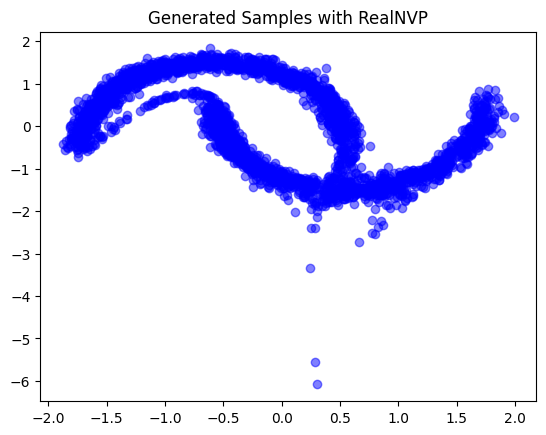

In [5]:
dataset = MoonsDataset()
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = RealNVP(INPUT_DIM, COUPLING_DIM, COUPLING_LAYERS).to(DEVICE)

train(model, loader, EPOCHS, LR)

# Sampling
samples = model.sample(3000).cpu().detach().numpy()

plt.scatter(samples[:,0], samples[:,1], alpha=0.5, color='blue')
plt.title('Generated Samples with RealNVP')
plt.show()